In [1]:
using AutoGrad: full
using LinearAlgebra
using Knet
include("../src/optimizer.jl");
include("../src/helperfunctions.jl");

In [2]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"] = 72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Random: shuffle!
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Knet: Knet, AutoGrad, param, param0, mat, RNN, relu, Data, adam, progress, nll, zeroone

In [3]:
println("deneme")

deneme


In [5]:
include(Knet.dir("data/nltk.jl"))
(data,words,tags) = brown()
println("The Brown Corpus has $(length(data)) sentences, $(sum(length(p[1]) for p in data)) tokens, with a word vocabulary of $(length(words)) and a tag vocabulary of $(length(tags)).")

The Brown Corpus has 57340 sentences, 1161192 tokens, with a word vocabulary of 56057 and a tag vocabulary of 472.


In [6]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)

In [7]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)

In [8]:
struct Embed; w; end
Embed(vocabsize::Int,embedsize::Int) = Embed(param(embedsize,vocabsize))
(e::Embed)(x) = e.w[:,x]

In [9]:
Tagger0(vocab,embed,hidden,output)=  # MLP Tagger
    Chain(Embed(vocab,embed),Dense(embed,hidden,relu),Dense(hidden,output))
Tagger1(vocab,embed,hidden,output)=  # RNN Tagger
    Chain(Embed(vocab,embed),RNN(embed,hidden,rnnType=:relu),Dense(hidden,output))
Tagger2(vocab,embed,hidden,output)=  # biRNN Tagger
    Chain(Embed(vocab,embed),RNN(embed,hidden,rnnType=:relu,bidirectional=true),Dense(2hidden,output));

In [10]:
BATCHSIZE = 64
SEQLENGTH = 32;

In [11]:
function seqbatch(x,y,B,T)
    N = length(x) ÷ B
    x = permutedims(reshape(x[1:N*B],N,B))
    y = permutedims(reshape(y[1:N*B],N,B))
    d = []; for i in 0:T:N-T
        push!(d, (x[:,i+1:i+T], y[:,i+1:i+T]))
    end
    return d
end
allw = vcat((x->x[1]).(data)...)
allt = vcat((x->x[2]).(data)...)
d = seqbatch(allw, allt, BATCHSIZE, SEQLENGTH);

In [12]:
embedlayer = Embed(length(words),128)
summary(embedlayer(x))

UndefVarError: UndefVarError: x not defined

In [13]:
shuffle!(d)
dtst = d[1:10]
dtrn = d[11:end]
length.((dtrn,dtst))

(556, 10)

In [36]:
function trainresults(file,maker,savemodel)
    if (print("Train from scratch? "); readline()[1]=='y')
        model = maker()
        results = ((nll(model,dtst), zeroone(model,dtst))
                   for x in takenth(progress(sm3(model,ncycle(dtrn,100))),100))
        results = reshape(collect(Float32,flatten(results)),(2,:))
        Knet.save(file,"model",(savemodel ? model : nothing),"results",results)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        model,results = Knet.load(file,"model","results")
    end
    println(minimum(results,dims=2))
    return model,results
end

trainresults (generic function with 1 method)

In [15]:
VOCABSIZE = length(words)
EMBEDSIZE = 128
HIDDENSIZE = 128
OUTPUTSIZE = length(tags);

In [16]:
# 2.35e-01  100.00%┣┫ 2780/2780 [00:13/00:13, 216.36i/s] [0.295007; 0.0972656]
t0maker() = Tagger0(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
(t0,r0) = trainresults("tagger134a.jld2",t0maker,false);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 2780/2780, 00:50/00:50, 55.43i/s] 


Float32[0.31332785; 0.09741211]


In [17]:
# 1.49e-01  100.00%┣┫ 2780/2780 [00:19/00:19, 142.58i/s] [0.21358; 0.0616211]
t1maker() = Tagger1(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
(t1,r1) = trainresults("tagger134b.jld2",t1maker,false);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 2780/2780, 00:15/00:15, 183.08i/s] 


Float32[0.23739955; 0.06689453]


In [18]:
# 9.37e-02  100.00%┣┫ 2780/2780 [00:25/00:25, 109.77i/s] [0.156669; 0.044043]
t2maker() = Tagger2(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
(t2,r2) = trainresults("tagger134c.jld2",t2maker,true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 2780/2780, 00:15/00:15, 189.26i/s] 


Float32[0.17934099; 0.048828125]


In [19]:
using Plots; default(fmt=:png,ls=:auto,ymirror=true)

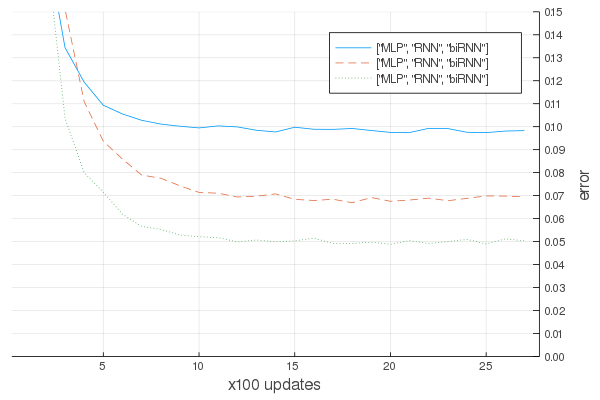

In [20]:
plot([r0[2,:], r1[2,:], r2[2,:]]; xlabel="x100 updates", ylabel="error",
    ylim=(0,0.15), yticks=0:0.01:0.15, labels=["MLP","RNN","biRNN"])

In [37]:
(t2_sm3, r2_sm3) = trainresults("taggersm3134c.jld2", t2maker, true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 55600/55600, 05:33/05:33, 167.07i/s] 


Float32[0.58914137; 0.121679686]


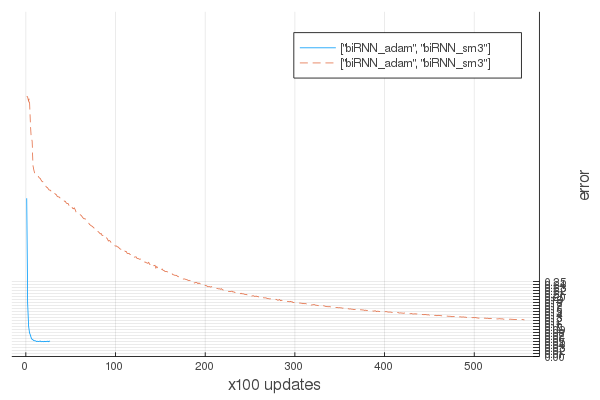

In [46]:
plot([r2[2,:], r2_sm3[2,:]]; xlabel="x100 updates", ylabel="error",
    ylim=(0,1.15), yticks=0:0.01:0.25, labels=["biRNN_adam", "biRNN_sm3"])